In [1]:
from ssht_heatnet import HeatNet
from ssht_datageneration import generate_domain_points, generate_boundary_points
from ssht_loss_fns import pde_loss_2d, bc_loss_2d, data_loss_2d

import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


In [2]:
# generating data for the data loss (data points - where the prediction is compared to true values)

def analytic_solution(x, y, terms = 40):

    T = np.zeros_like(x)
    for n in range(1, 2*terms, 2):  # odd n only
        coef = (4 / (n * np.pi))
        numerator = np.sinh(n * np.pi * y)
        denominator = np.sinh(n * np.pi)
        T += coef * (numerator / denominator) * np.sin(n * np.pi * x)
    return T
    


n_data = 100
x_data, y_data = generate_domain_points(n_data)
T_data = analytic_solution(x_data, y_data, terms=1)


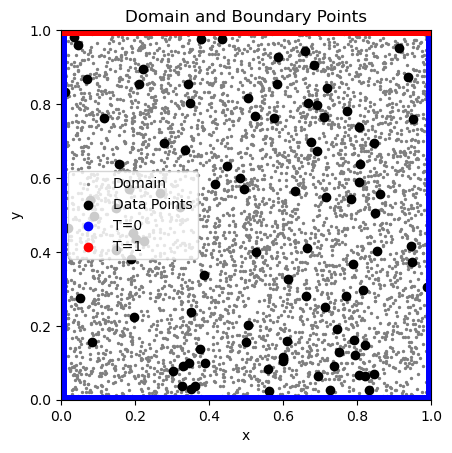

In [3]:
# generating specific training data (collocation points - where the pde residual is calculated)

n_domain = 5000
n_bc = 2500
x_domain, y_domain = generate_domain_points(n_domain)
x_bc, y_bc, t_bc = generate_boundary_points(n_bc)

plt.scatter(x_domain, y_domain, c='gray', s=2, label='Domain')
plt.scatter(x_data, y_data, c='k', label='Data Points')
plt.scatter(x_bc[t_bc==0], y_bc[t_bc==0], c='b', label='T=0')
plt.scatter(x_bc[t_bc==1], y_bc[t_bc==1], c='r', label='T=1')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Domain and Boundary Points')
plt.legend()
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [4]:
#instantiate the model

model = HeatNet(
    input_dim=2, output_dim=1, n_units=60, epochs=500, lr=0.001,
    pde_loss=pde_loss_2d, bc_loss=bc_loss_2d, pde_weight=1.0, bc_weight=100.0,
    use_ffe=False, num_frequencies=16, fourier_scale=1,
    data_loss=data_loss_2d, data_weight=1.0)

Epoch 0: Loss (tot) 21.903, Loss (pde) 0.00015908386558294296, Loss (bc) 21.811073303222656, Loss (data) 0.09204909950494766 
Epoch 50: Loss (tot) 9.305, Loss (pde) 0.12193654477596283, Loss (bc) 9.15577220916748, Loss (data) 0.02766224928200245 
Epoch 100: Loss (tot) 7.040, Loss (pde) 0.26247379183769226, Loss (bc) 6.757297515869141, Loss (data) 0.020208023488521576 
Epoch 150: Loss (tot) 3.761, Loss (pde) 0.3935851752758026, Loss (bc) 3.357598304748535, Loss (data) 0.010014478117227554 
Epoch 200: Loss (tot) 2.957, Loss (pde) 0.1745097041130066, Loss (bc) 2.7761852741241455, Loss (data) 0.006528854835778475 
Epoch 250: Loss (tot) 2.606, Loss (pde) 0.1349472850561142, Loss (bc) 2.4657490253448486, Loss (data) 0.005369945894926786 
Epoch 300: Loss (tot) 2.517, Loss (pde) 0.11965284496545792, Loss (bc) 2.391690969467163, Loss (data) 0.005257401615381241 
Epoch 350: Loss (tot) 2.457, Loss (pde) 0.10137736797332764, Loss (bc) 2.3509421348571777, Loss (data) 0.004831718746572733 
Epoch 400

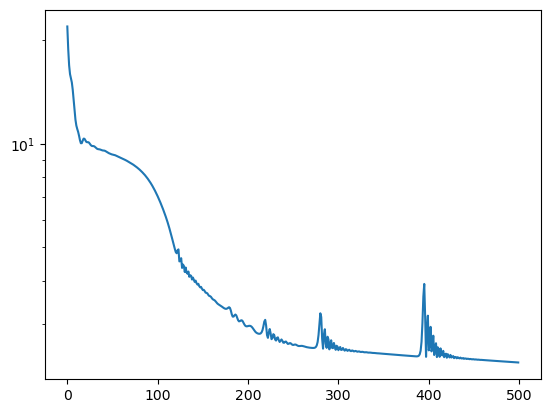

In [5]:
#losses calculation


losses = model.fit(x_domain, y_domain, x_bc, y_bc, t_bc, x_data, y_data, T_data)

plt.plot(losses)
plt.yscale('log')

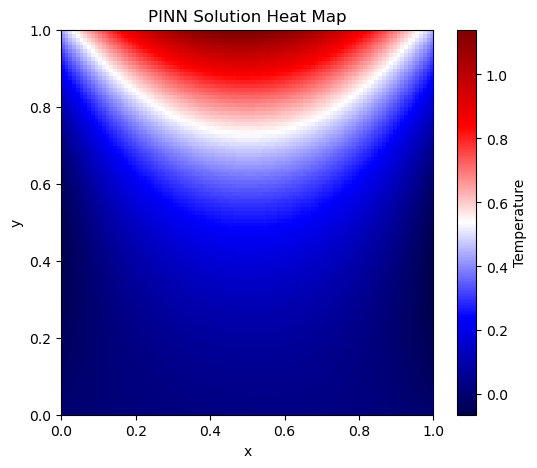

In [6]:
# now using the pinn, trained on random data, to estimate the solution to the heat equation everywhere
# in the grid, ie giving a heat map


# Create a regular grid
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()


# Predict on the grid
xy = torch.tensor(np.stack([x_flat, y_flat], axis=1), dtype=torch.float32)
with torch.no_grad():
    T_pred = model(xy).cpu().numpy().reshape(n, n)


# Plot heatmap
plt.figure(figsize=(6,5))
plt.imshow(T_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PINN Solution Heat Map')
plt.show()

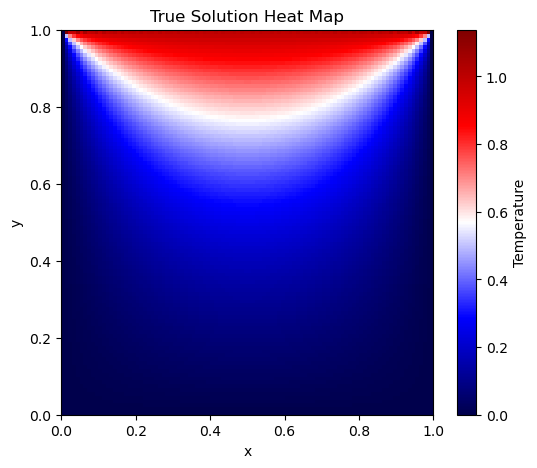

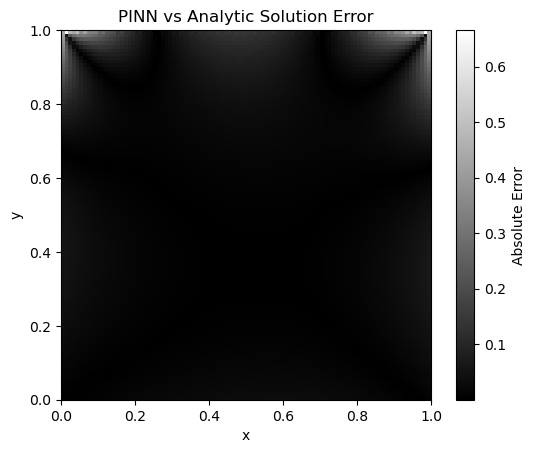

In [7]:
# Now to see a heatmap of the error (analytic solution - PINNs predictions)
    
T_true_grid = analytic_solution(X, Y)
error_grid = np.abs(T_pred - T_true_grid)

plt.figure(figsize=(6,5))
plt.imshow(T_true_grid, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True Solution Heat Map')
plt.show()

plt.imshow(error_grid, extent=[0,1,0,1], origin='lower', cmap='gray')
# extent=[xmin, xmax, ymin, ymax] ;  imshow puts origin top left so 'lower' moves it to bottom left
plt.colorbar(label='Absolute Error')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PINN vs Analytic Solution Error')
plt.show()